In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ca = pd.read_csv('customer_analytics.csv')
pp = pd.read_csv('product_performance.csv')

In [4]:
ca.head()

,Customer_ID,Age,Gender,Purchase_Amount_USD,Location,Category,Season,Review_Rating,Previous_Purchases,Subscription_Status,Discount_Applied,Promo_Code_Used,Payment_Method,Frequency_of_Purchases,customer_segment,customer_type
0,1,55,Male,53,Kentucky,Clothing,Winter,3.1,14,Yes,Yes,Yes,Venmo,Fortnightly,Medium Value,Regular
1,2,19,Male,64,Maine,Clothing,Winter,3.1,2,Yes,Yes,Yes,Cash,Fortnightly,Medium Value,New
2,3,50,Male,73,Massachusetts,Clothing,Spring,3.1,23,Yes,Yes,Yes,Credit Card,Weekly,Medium Value,Regular
3,4,21,Male,90,Rhode Island,Footwear,Spring,3.5,49,Yes,Yes,Yes,PayPal,Weekly,High Value,Loyal
4,5,45,Male,49,Oregon,Clothing,Spring,2.7,31,Yes,Yes,Yes,PayPal,Annually,Low Value,Loyal


In [5]:
pp.head()

,product_id,product_name,main_category,selling_price,times_sold,total_revenue
0,0000fe97fd6c7705b08b7f4c7c5312ce,Banpresto 39652 Dragon Ball Super Blood of Sai...,Unknown,17.900000,1,17.9
1,00037729f1cb566e149f0beff2d9ffd3,Pokeno 2,Toys & Games,15.010000,0,0.0
2,0003a7ccfb779e7ac1664fb13145aff2,Medicom JUL188832 Peanuts: Surfer Snoopy Ultra...,Unknown,9.940000,0,0.0
3,000f59b5765a88b998642b4fa5ffdc17,Darice 1177-01 Percussion Instrument D Shape w...,Toys & Games,6.900000,0,0.0
4,001bd04642c7cb9f5c888fe8a993987b,Dream On Me Tiny Toes Walker in Beige,Baby Products,42.990002,0,0.0


In [ ]:
#K Means Clustering

In [6]:
ca['Gender_encoded'] = ca['Gender'].map({'Male':1, 'Female':0})

In [7]:
ca = pd.get_dummies(ca, columns=['Location'], drop_first=True)

In [29]:
freq_cols = [col for col in ca.columns if col.startswith('Frequency_of_Purchases')]

def get_frequency_label(row):
    for col in freq_cols:
        if row[col] == 1:
            return col.replace('Frequency_of_Purchases_', '')
    return None

ca['Frequency_Label'] = ca.apply(get_frequency_label, axis=1)

In [30]:
frequency_mapping = {
    'Weekly': 6,
    'Fortnightly': 5,
    'Bi-Weekly': 4,
    'Monthly': 3,
    'Every 3 Months': 2,
    'Quarterly': 1
}

ca['Frequency_Score'] = ca['Frequency_Label'].map(frequency_mapping)

In [31]:
ca = ca.drop(columns=freq_cols)

In [32]:
features = [
    'Purchase_Amount_USD',
    'Previous_Purchases',
    'Frequency_Score',
    'Age',
    'Gender_encoded'
] + [col for col in ca.columns if col.startswith('Location_')]

In [13]:
from sklearn.preprocessing import StandardScaler

In [42]:
X = ca[features]

In [43]:
ca[features].isna().sum()

Purchase_Amount_USD        0
Previous_Purchases         0
Frequency_Score            0
Age                        0
Gender_encoded             0
Location_Alaska            0
Location_Arizona           0
Location_Arkansas          0
Location_California        0
Location_Colorado          0
Location_Connecticut       0
Location_Delaware          0
Location_Florida           0
Location_Georgia           0
Location_Hawaii            0
Location_Idaho             0
Location_Illinois          0
Location_Indiana           0
Location_Iowa              0
Location_Kansas            0
Location_Kentucky          0
Location_Louisiana         0
Location_Maine             0
Location_Maryland          0
Location_Massachusetts     0
Location_Michigan          0
Location_Minnesota         0
Location_Mississippi       0
Location_Missouri          0
Location_Montana           0
Location_Nebraska          0
Location_Nevada            0
Location_New Hampshire     0
Location_New Jersey        0
Location_New M

In [40]:
for col in ['Frequency_Score']:
    ca[col] = ca[col].fillna(ca[col].median())

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
from sklearn.cluster import KMeans

In [46]:
inertia = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

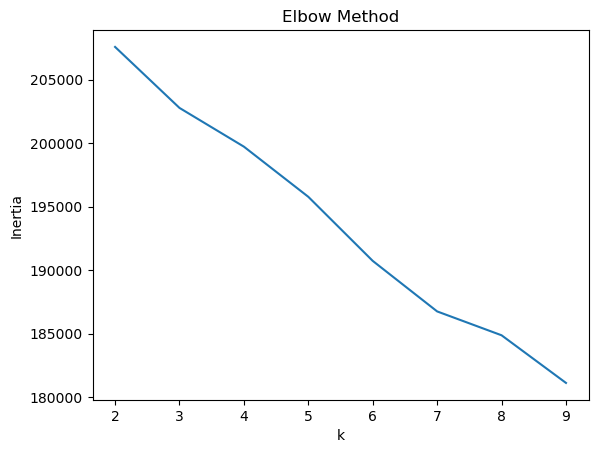

In [83]:
plt.plot(range(2,10), inertia)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.savefig('Kmeans_Graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
kmeans = KMeans(n_clusters=5, random_state=42)
ca['Cluster'] = kmeans.fit_predict(X_scaled)

In [61]:
summary = ca.groupby('Cluster').agg({
    'Purchase_Amount_USD': 'mean',
    'Previous_Purchases': 'mean',
    'Frequency_Score': 'mean',
    'Age': 'mean',
    'Gender_encoded': 'mean',
    'Customer_ID': 'count'
})
print(summary)

         Purchase_Amount_USD  Previous_Purchases  Frequency_Score        Age  \
Cluster                                                                        
0                  66.567568           27.418919         3.351351  42.972973   
1                  61.194805           21.480519         3.402597  42.740260   
2                  57.685519           25.128651         4.713487  43.090118   
3                  61.191953           25.696558         2.366457  45.000000   
4                  56.987013           22.649351         3.402597  41.935065   

         Gender_encoded  Customer_ID  
Cluster                               
0              0.635135           74  
1              0.571429           77  
2              0.689869         1609  
3              0.679108         2063  
4              0.649351           77  


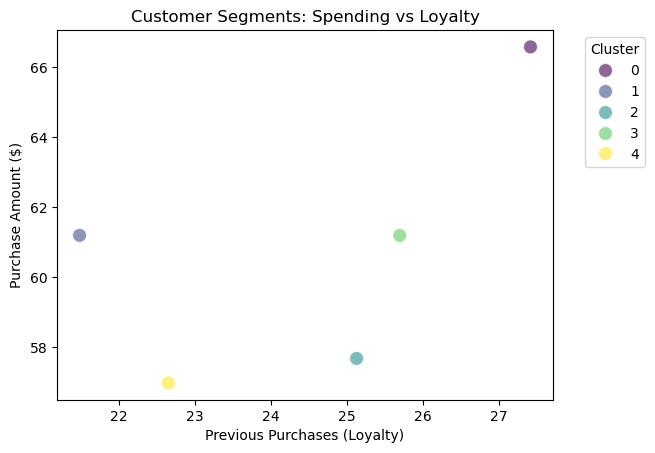

In [62]:
# Scatter plot: Purchase Amount vs Previous Purchases
sns.scatterplot(data=summary, 
                x='Previous_Purchases', 
                y='Purchase_Amount_USD', 
                hue='Cluster', 
                palette='viridis', 
                s=100, 
                alpha=0.6)
plt.title('Customer Segments: Spending vs Loyalty')
plt.xlabel('Previous Purchases (Loyalty)')
plt.ylabel('Purchase Amount ($)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('customer_segments.png', dpi=300, bbox_inches='tight')
plt.show()

In [78]:
summary = summary.reset_index()   # adds 'Cluster' as a column
cluster_names = {
    0: 'VIP High Spenders',
    1: 'Premium Regular',
    2: 'Frequent Bargain Hunters',
    3: 'Occasional Shoppers',
    4: 'Budget Newcomers'
}
summary['Segment_Name'] = summary['Cluster'].map(cluster_names)

In [79]:
print(summary)

   level_0  index  Cluster  Purchase_Amount_USD  Previous_Purchases  \
0        0      0        0            66.567568           27.418919   
1        1      1        1            61.194805           21.480519   
2        2      2        2            57.685519           25.128651   
3        3      3        3            61.191953           25.696558   
4        4      4        4            56.987013           22.649351   

   Frequency_Score        Age  Gender_encoded  Customer_ID  \
0         3.351351  42.972973        0.635135           74   
1         3.402597  42.740260        0.571429           77   
2         4.713487  43.090118        0.689869         1609   
3         2.366457  45.000000        0.679108         2063   
4         3.402597  41.935065        0.649351           77   

               Segment_Name  
0         VIP High Spenders  
1           Premium Regular  
2  Frequent Bargain Hunters  
3       Occasional Shoppers  
4          Budget Newcomers  


In [65]:
summary.to_csv('customers_with_segments.csv', index=False)

In [80]:
# Calculate total value per segment
ca['Segment_Name'] = ca['Cluster'].map(cluster_names)
segment_value = ca.groupby('Segment_Name').agg({
    'Customer_ID': 'count',
    'Purchase_Amount_USD': ['sum', 'mean'],
    'Previous_Purchases': 'mean',
    'Frequency_Score': 'mean'
}).round(2)

segment_value.columns = ['Customer_Count', 'Total_Revenue', 'Avg_Purchase', 'Avg_Previous', 'Avg_Frequency']
segment_value = segment_value.sort_values('Total_Revenue', ascending=False)

#Revenue percentage
segment_value['Revenue_%'] = (segment_value['Total_Revenue'] / segment_value['Total_Revenue'].sum() * 100).round(2)

In [81]:
print("SEGMENT VALUE ANALYSIS:")
print(segment_value)

SEGMENT VALUE ANALYSIS:
                          Customer_Count  Total_Revenue  Avg_Purchase  \
Segment_Name                                                            
Occasional Shoppers                 2063         126239         61.19   
Frequent Bargain Hunters            1609          92816         57.69   
VIP High Spenders                     74           4926         66.57   
Premium Regular                       77           4712         61.19   
Budget Newcomers                      77           4388         56.99   

                          Avg_Previous  Avg_Frequency  Revenue_%  
Segment_Name                                                      
Occasional Shoppers              25.70           2.37      54.16  
Frequent Bargain Hunters         25.13           4.71      39.82  
VIP High Spenders                27.42           3.35       2.11  
Premium Regular                  21.48           3.40       2.02  
Budget Newcomers                 22.65           3.40       1.

In [82]:
segment_value.to_csv('segment_summary.csv')

In [180]:
#Customer Churn Prediction

In [181]:
df = pd.read_csv('customers_clean.csv')

In [182]:
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [184]:
df['Subscription Status'].value_counts()

Subscription Status
No     2847
Yes    1053
Name: count, dtype: int64

In [185]:
df["Churn"] = df["Subscription Status"].map({"No": 1, "Yes": 0})

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [187]:
X = df.drop(['Churn', 'Customer ID', 'Subscription Status', 'Shipping Type'], axis=1)
y = df['Churn']

In [189]:
from sklearn.model_selection import train_test_split

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

In [191]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [192]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [193]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),                  
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [194]:
from sklearn.ensemble import RandomForestClassifier

In [195]:
rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

In [196]:
from sklearn.pipeline import Pipeline

In [197]:
rfc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rfc)
])

In [198]:
rfc_pipeline.fit(X_train, y_train)
rfc_pred = rfc_pipeline.predict(X_test)
rfc_pred_proba = rfc_pipeline.predict_proba(X_test)[:, 1]

In [199]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [200]:
print("RANDOM FOREST RESULTS")
print(f"Accuracy: {accuracy_score(y_test, rfc_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, rfc_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rfc_pred, target_names=['Yes', 'No']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rfc_pred))

RANDOM FOREST RESULTS
Accuracy: 0.8308
ROC-AUC Score: 0.8914

Classification Report:
              precision    recall  f1-score   support

         Yes       0.63      0.90      0.74       316
          No       0.96      0.80      0.87       854

    accuracy                           0.83      1170
   macro avg       0.79      0.85      0.81      1170
weighted avg       0.87      0.83      0.84      1170


Confusion Matrix:
[[285  31]
 [167 687]]


In [283]:
acc = accuracy_score(y_test, rfc_pred)

In [284]:
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy"],
    "Value": [acc]
})

In [285]:
metrics_df.to_csv("model_evaluation_metrics.csv", index=False)

In [271]:
cm = confusion_matrix(y_test, rfc_pred)

# Convert to dataframe format for Power BI
cm_data = pd.DataFrame({
    'Actual': ['Churn', 'Churn', 'No Churn', 'No Churn'],
    'Predicted': ['Churn', 'No Churn', 'Churn', 'No Churn'],
    'Count': [cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
})

# Add labels
cm_data['Label'] = ['True Positive', 'False Negative', 'False Positive', 'True Negative']

print(cm_data)

     Actual Predicted  Count           Label
0     Churn     Churn    285   True Positive
1     Churn  No Churn     31  False Negative
2  No Churn     Churn    167  False Positive
3  No Churn  No Churn    687   True Negative


In [273]:
cm_data.to_csv("confusion_matrix.csv", index=False)

In [201]:
feature_names = rfc_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rfc_pipeline.named_steps['classifier'].feature_importances_

In [202]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

In [286]:
# Top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

Top 10 Most Important Features:
                        Feature  Importance
118    cat__Discount Applied_No    0.124672
120     cat__Promo Code Used_No    0.114826
119   cat__Discount Applied_Yes    0.105486
121    cat__Promo Code Used_Yes    0.097188
1    num__Purchase Amount (USD)    0.039543
3       num__Previous Purchases    0.037838
0                      num__Age    0.036773
2            num__Review Rating    0.032832
4            cat__Gender_Female    0.022630
5              cat__Gender_Male    0.018500


In [206]:
import joblib

In [207]:
joblib.dump(rfc_pipeline, 'rf=rfc_pipeline.pkl')

['rf=rfc_pipeline.pkl']

In [208]:
#Make Full Prediction on Dataset

In [209]:
X_full = df.drop(['Churn', 
                  'Customer ID', 
                  'Subscription Status', 
                  'Shipping Type'], axis=1)

In [210]:
df["Churn_Prediction"] = rfc_pipeline.predict(X_full)

In [211]:
df["Churn_Prob"] = rfc_pipeline.predict_proba(X_full)[:, 1]

In [212]:
def risk_category(prob):
    if prob >= 0.66:
        return 'High Risk'
    elif prob >= 0.33:
        return 'Medium Risk'
    else:
        return 'Low Risk'
df["Churn_Risk_Level"] = df["Churn_Prob"].apply(risk_category)

In [213]:
df.to_csv("churn_predictions_with_risk.csv", index=False)

In [214]:
#Product Recommendation

In [244]:
df_products = pd.read_csv('customers_clean.csv')

In [245]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [258]:
df_products = df.groupby('Item Purchased').agg({
    'Category': 'first',
    'Color': 'first',
    'Size': 'first',
    'Season': 'first',
    'Purchase Amount (USD)': 'median',  
    'Review Rating': 'mean',             
    'Discount Applied': 'first',
    'Promo Code Used': 'first',
    'Payment Method': 'first'
}).reset_index()

In [259]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [260]:
df_products['Product_Description'] = (
    df_products['Item Purchased'].astype(str) + " " +
    df_products['Category'].astype(str) + " " +
    df_products['Color'].astype(str) + " " +
    df_products['Size'].astype(str) + " " +
    df_products['Season'].astype(str) + " " +
    df_products['Discount Applied'].astype(str) + " " +
    df_products['Promo Code Used'].astype(str) + " " +
    df_products['Payment Method'].astype(str) + " " +
    df_products['Purchase Amount (USD)'].astype(str) + " price " +
    df_products['Review Rating'].astype(str) + " stars"
)

In [261]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_products['Product_Description'])

In [262]:
similarity_matrix = cosine_similarity(tfidf_matrix)

In [263]:
def recommend_products(item_name, n=5):
    # Find the index of the product
    if item_name not in df_products['Item Purchased'].values:
        return ["Product not found"]

    idx = df_products.index[df_products['Item Purchased'] == item_name][0]
    
    # Get similarity scores
    scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort scores in descending order
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    # Skip the first one (same product)
    top_scores = scores[1:n+1]
    
    # Return recommended product names
    recommendations = df_products.iloc[[i[0] for i in top_scores]]['Item Purchased'].values
    return recommendations

In [264]:
recommend_products("Handbag")

array(['Sweater', 'Jewelry', 'Gloves', 'Sunglasses', 'Belt'], dtype=object)

In [265]:
df['Recommended_Product'] = df['Item Purchased'].apply(
    lambda x: recommend_products(x, 1)[0]
)

In [266]:
df.to_csv("enhanced_product_recommendations.csv", index=False)